In [1]:
import json
import os
import re
import pandas as pd



model = "meta-llama/Llama-2-7b-hf"

model_suffix = model.split("/")[-1]

path = f"../output/{model_suffix}/lora"

# List subdirectories in the path
subdirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

# Read JSON files starting with "output" from each subdirectory
data = []
for subdir in subdirs:
    subdir_path = os.path.join(path, subdir)
    json_files = [f for f in os.listdir(subdir_path) if f.startswith("output") and f.endswith(".json")]

    
    # Read each JSON file and extract metrics key which is a key value map
    for json_file in json_files:
        # Get step from the filename which is in the format "output{.}*step=123.json"
        step_match = re.search(r'step=(\d+)', json_file)
        step = int(step_match.group(1)) if step_match else None
        json_path = os.path.join(subdir_path, json_file)
        with open(json_path, 'r') as f:
            json_data = json.load(f)
            metrics = json_data.get("metrics", {})
            ppl = json_data.get("ppl", {}).get("mean", None)
            json_data = { 
                "step": step,
                "subdir": subdir,
                "ppl": ppl,
                **metrics
            }

            data.append(json_data)
# Create a DataFrame from the collected data
df = pd.DataFrame(data)


In [2]:
# Plot auroc across steps for each subdir
subdirs = ["kgw_distilled", "gaussmark", "mb_k256"]
rename_map = {
    "kgw_distilled": "KGW Distilled",
    "gaussmark": "GaussMark",
    "mb_k256": "OpenStamp"
}
df_filtered = df[df['subdir'].isin(subdirs)]
# Rename subdirs for better readability in the plot
df_filtered['subdir'] = df_filtered['subdir'].replace(rename_map)

[]


/tmp/ipykernel_4191429/1630504522.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = plt.legend(


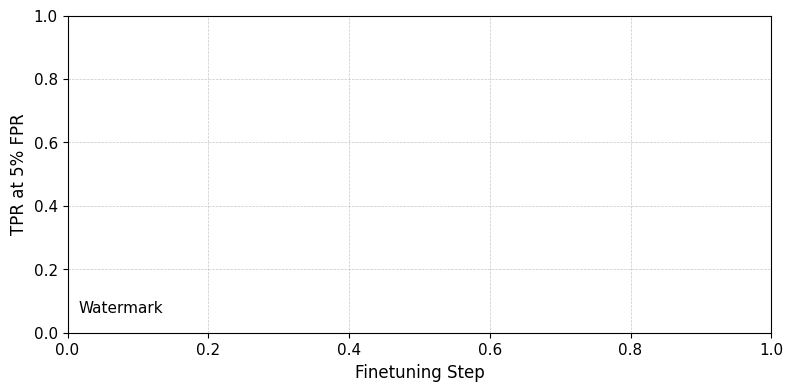

In [3]:

print(df_filtered['subdir'].unique())


import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
for i, subdir in enumerate(sorted(df_filtered['subdir'].unique())):
    subdir_data = df_filtered[df_filtered['subdir'] == subdir].sort_values(by='step')
    plt.plot(
        subdir_data['step'],
        subdir_data['tpr_5_fpr'],
        label=subdir,
        color=colors[i % len(colors)],
        marker='o',
        linewidth=2,
        markersize=6
    )
plt.xlabel('Finetuning Step', fontsize=12)
plt.ylabel('TPR at 5% FPR', fontsize=12)
legend = plt.legend(
    title="Watermark",
    fontsize=9,
    title_fontsize=11,
    loc='lower left',
    frameon=False
)

plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

In [ ]:
# Compare average rate of decrease in TPR at 5% FPR across subdirs
avg_tpr_decrease = df_filtered.groupby('subdir')['tpr_5_fpr'].mean().sort_values(ascending=False)
print("Average TPR at 5% FPR across subdirs:")
print(avg_tpr_decrease)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assume df has columns: subdir, step, ppl

# Get step 0 PPL per subdir
step0_ppl = df_filtered[df_filtered['step'] == 0][['subdir', 'ppl']].set_index('subdir')['ppl']

# Map step 0 PPL to all rows
df_filtered['step0_ppl'] = df_filtered['subdir'].map(step0_ppl)

# Compute difference from step 0
df_filtered['ppl_diff'] = df_filtered['ppl'] - df_filtered['step0_ppl']

# Pivot to create heatmap matrix: rows=subdir, columns=step
heatmap_data = df_filtered.pivot(index='subdir', columns='step', values='ppl_diff')

# Exclude step 0 from the heatmap
heatmap_data = heatmap_data.drop(columns=[0], errors='ignore')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='coolwarm', center=0, cbar_kws={'label': 'PPL Difference from Step 0'})
plt.title('PPL Difference from Step 0 Across Finetuning Steps')
plt.xlabel('Step')
plt.ylabel('Watermark')
plt.tight_layout()
plt.show()
